In [39]:
import os  # helps you to interact with operating system, 
# managing files and directories 
# finding current directories, 
# working with enviornment variables 
import pandas as pd  # for dataframe 
import numpy as np  # handaling arrays
import cv2  # used for image processing and computer vision
# read and write files, Object detections(faces) and more 
import matplotlib.pyplot as plt 
from tqdm import tqdm # shows the level of progress
import random 
import concurrent.futures # for parallel execution of tasks 

In [21]:
train_path = "/Users/meetsudra/Downloads/DiabeticRetino/archive/dr_unified_v2/dr_unified_v2/train"

print("Classes: ",sorted(os.listdir(train_path)))

Classes:  ['0', '1', '2', '3', '4']


## Sample Image

(-0.5, 1023.5, 730.5, -0.5)

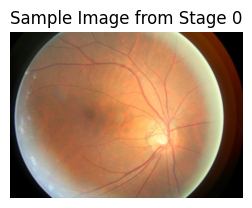

In [22]:
sample_imgpath = os.path.join(train_path,"0",os.listdir(os.path.join(train_path,"0"))[0])

# read image using OpenCV
img = cv2.imread(sample_imgpath)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(3,3))
plt.imshow(img)
plt.title("Sample Image from Stage 0")
plt.axis("off")

## Creating Dataset

Resource already had categorised images into train test and validation sets, to avoid preprocessing these folders individually will combine them into one and split it after preprocessing them to maintain the consistency 

In [23]:
dataset_path = "/Users/meetsudra/Downloads/DiabeticRetino/archive/dr_unified_v2/dr_unified_v2"
folders = ["train","test","val"]

image_paths = []
labels = []

for folder in folders:
    folder_path = os.path.join(dataset_path,folder)
    for category in sorted(os.listdir(folder_path)):
        category_path = os.path.join(folder_path,category)
        for img_name in os.listdir(category_path):
            img_path = os.path.join(category_path,img_name)
            image_paths.append(img_path)
            labels.append(int(category))

# unified dataframe
df = pd.DataFrame({"image_path": image_paths, "label":labels})
df.head()

,image_path,label
0,/Users/meetsudra/Downloads/DiabeticRetino/arch...,0
1,/Users/meetsudra/Downloads/DiabeticRetino/arch...,0
2,/Users/meetsudra/Downloads/DiabeticRetino/arch...,0
3,/Users/meetsudra/Downloads/DiabeticRetino/arch...,0
4,/Users/meetsudra/Downloads/DiabeticRetino/arch...,0


## Distribution of Images 

In [24]:
df.shape

(92501, 2)

In [25]:
# Check number of images per stage 

image_counts = df['label'].value_counts().sort_index()
image_counts

label
0    68953
1     4634
2    15151
3     1259
4     2504
Name: count, dtype: int64

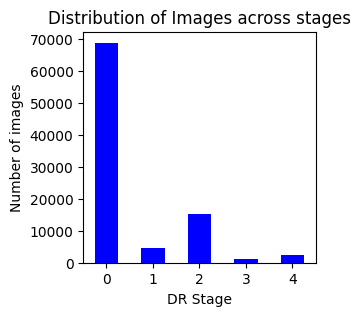

In [26]:
# Plot distribution of images 
plt.figure(figsize=(3,3))

image_counts.plot(kind='bar',color='blue')
plt.xlabel("DR Stage")
plt.ylabel("Number of images")
plt.xticks(rotation=0)
plt.title("Distribution of Images across stages")
plt.show()

This shows that our dataset is highly imbalanced. There are more number of images of stage 0 which might build our model biased

## Identifying and removing corrupted images if any

In [27]:
# Function to calculate images if any 

def is_corrupted(image_path):
    try:
        img = cv2.imread(image_path)
        if img is None:
            return True  # image is corrupted 
        return False 
    except:
        return True 
    
# Detect corrupted images 
corrupted_images = [img_path for img_path in df['image_path'] if is_corrupted(img_path)]

In [29]:
# Display results 
print(f"Total images checked:{len(df)}")
print(f"Corrupted images found:{len(corrupted_images)}")

df = df[~df["image_path"].isin(corrupted_images)].reset_index(drop=True)

Total images checked:92501
Corrupted images found:0


## Identifying and removing duplicates if any

In [30]:
# Function to calculate image hash (for detecting duplicates)
def dhash(image, hash_size=8): # 64 bit hash representation of image
    resized = cv2.resize(image, (hash_size+1, hash_size)) # side by side comparison at the end 8 by 8 recieved
    diff = resized[:,1:] > resized[:,:-1]
    return sum([2 ** i for (i,v) in enumerate(diff.flatten()) if v])

# Dictionary to store unique image hashes 
hashes = {}
duplicate_images = []

# Iterate through all images in the dataset with tqdm for process tracking
for img_path in tqdm(df["image_path"],desc="processing images"):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE) # read in grayscale for consistency 

    img_hash = dhash(img) # compute hash 

    if img_hash in hashes:
        duplicate_images.append(img_path) # Mark as duplicate
    else:
        hashes[img_hash] = img_path

duplicate_set = set(duplicate_images)

# drop duplicates from the dataframe 
df = df[~df["image_path"].isin(duplicate_set)].reset_index(drop=True)

# display results
print(f"Total images checked:{len(hashes)} (unique)")
print(f"Duplicate images removed:{len(duplicate_images)}")

processing images: 100%|██████████| 92501/92501 [05:16<00:00, 292.11it/s] 

Total images checked:90366 (unique)
Duplicate images removed:2135


In [31]:
# Check the number of images per stage 
image_counts = df["label"].value_counts().sort_index()
print("Number of images per stage:")
print(image_counts)

Number of images per stage:
label
0    67556
1     4470
2    14676
3     1225
4     2439
Name: count, dtype: int64


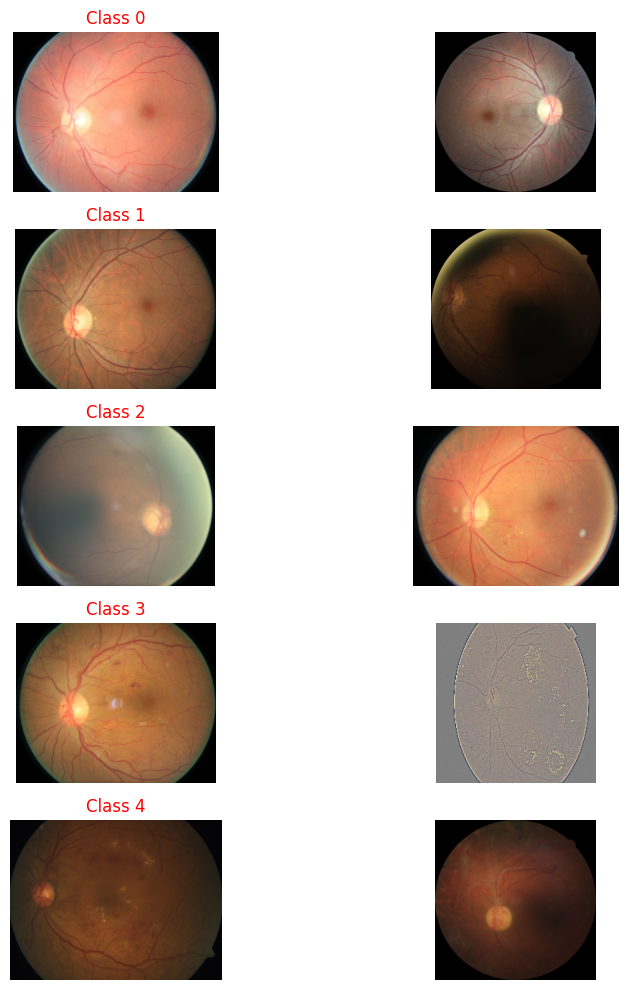

In [34]:
# Visualzing sample Images 

img_perclass = 2 
unique_labels = df["label"].unique()
fig, axes = plt.subplots(len(unique_labels), img_perclass, figsize=(10,10))

for i, label in enumerate(sorted(unique_labels)):
     sample_images = df[df['label'] == label]['image_path'].sample(img_perclass, random_state=42).tolist()
     for j, image_path in enumerate(sample_images):
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes[i, j].imshow(img)
        axes[i, j].axis("off")
        if j == 0:
            axes[i, j].set_title(f"Class {label}", fontsize=12, color='red')

plt.tight_layout()
plt.show()


#### Interpretations

1. Few images are blurry with low contrast whereas some are clear and well-lit
2. Class 1 second images seems to be of gray scale or poorly processed
3. Images would also need rotation and flipping
4. Images are of same resolution?
5. There is a visible progression of Diabetic Retinopathy severity as we move down to stage 4


## Resizing Images

In [37]:
# Function to get image size 
def get_image_size(image_path):
    img = cv2.imread(image_path)
    return img.shape[:2]

stages = df["label"].unique()

for stage in stages:
    stage_images = df[df["label"]==stage]["image_path"].tolist()

    random_images = random.sample(stage_images, 4) # want 4 from each

    print(f"\nStage: {stage}")
    for img_path in random_images:
        size = get_image_size(img_path)
        print(f"Size: {size}")


Stage: 0
Size: (1017, 1024)
Size: (1023, 1024)
Size: (820, 1024)
Size: (806, 1023)

Stage: 1
Size: (823, 1024)
Size: (1022, 1024)
Size: (912, 1024)
Size: (1022, 1024)

Stage: 2
Size: (1021, 1024)
Size: (1021, 1024)
Size: (826, 1024)
Size: (819, 1024)

Stage: 3
Size: (816, 1024)
Size: (2136, 3216)
Size: (797, 1024)
Size: (1023, 1023)

Stage: 4
Size: (224, 224)
Size: (811, 1024)
Size: (1019, 1024)
Size: (851, 1024)


1. Since images are of different sizes, resizing ensures they are on the same scale
2. Many pretrained models require a fixed input size, and 224×224 is a common standard

In [40]:
# Function to resize an image to 224*224

def resize_image(image_path):
    try:
        img = cv2.imread(image_path)
        img_resized = cv2.resize(img,(224,224))
        return image_path, img_resized
    except:
        return image_path, None # Skip images if any issue occurs

# Multiprocessing function
def resize_images_parallel(image_paths, max_workers=4):
    resized_images = {}

    with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
        results = executor.map(resize_image, image_paths)

        for image_path, resized in results:
            if resized is not None:
                resized_images[image_path] = resized  # Store valid resized images

    return resized_images
# Get all image paths from the DataFrame
image_paths = df["image_path"].tolist()

# Run multiprocessing resizing
resized_images_dict = resize_images_parallel(image_paths, max_workers=4)

# Update DataFrame with resized images
df["resized_image"] = df["image_path"].map(resized_images_dict)

print(f"Successfully resized {len(resized_images_dict)} images to 224x224!")

Successfully resized 90366 images to 224x224!
